In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# dataset from https://www.kaggle.com/robikscube/hourly-energy-consumption

# using pjm_hourly_est.csv file because it has the records of the whole PJM regions together
df = pd.read_csv('data/pjm_hourly_est.csv')

# sort by date
df.sort_values(by=['Datetime'], inplace=True)

# set Datetime as index
df.set_index('Datetime', inplace=True)

# convert index to datetime
df.index = pd.to_datetime(df.index)


df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-04-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259.0
1998-04-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21244.0
1998-04-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20651.0
1998-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20421.0
1998-04-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20713.0


In [9]:
# describing the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [10]:
# check for duplicates
df.duplicated().sum()

16181

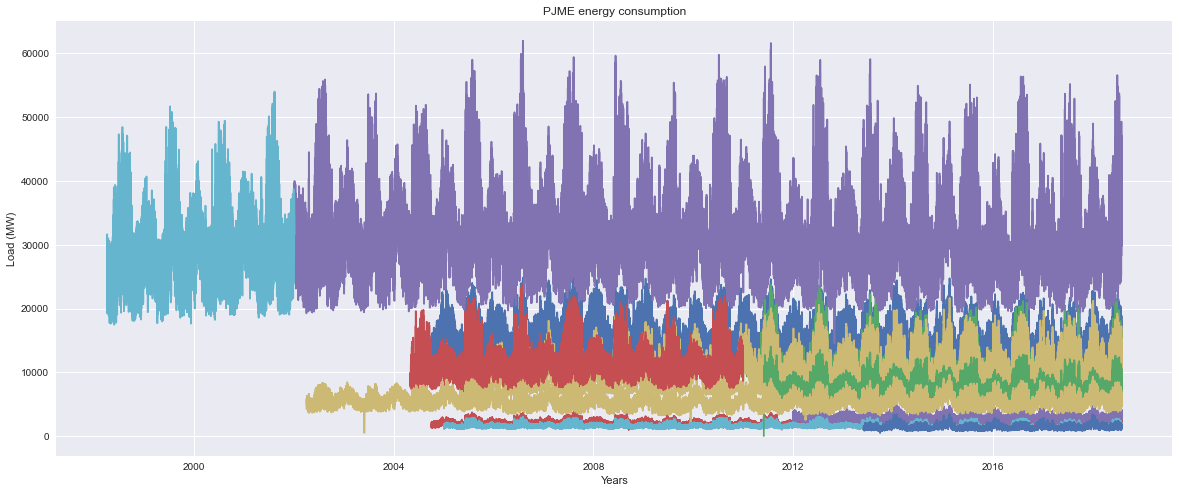

In [11]:

# Distribution of Load for all regions
plt.style.use('seaborn')
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

# we see that each region has a different energy consumption pattern
# so its better to make predictions for each region separately
# we choose the region with the most data "least missing values"

<AxesSubplot:>

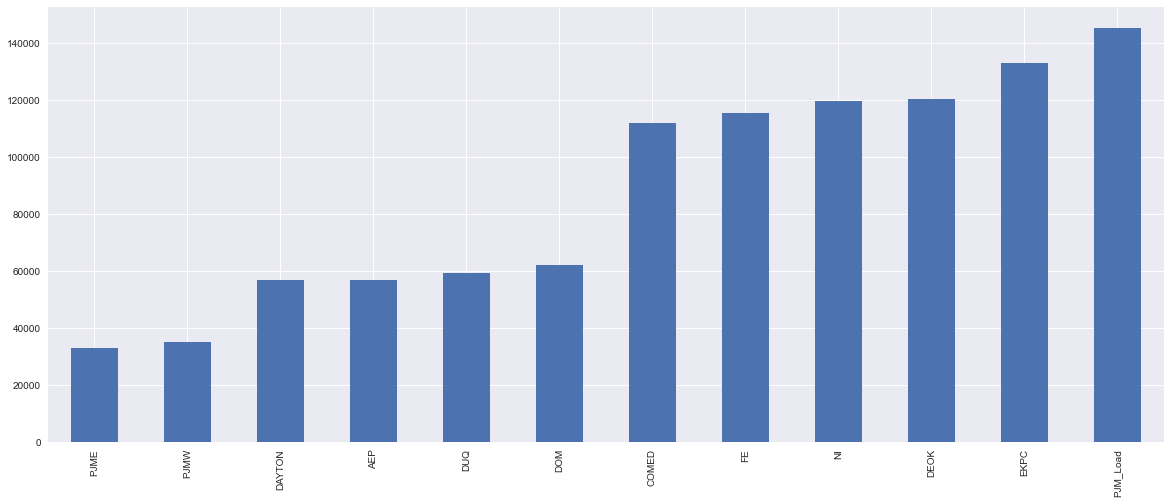

In [12]:
# check for missing values
missing_values_df = df.isnull().sum()

# plot the missing values
missing_values_df.sort_values(ascending=True).plot(kind='bar', figsize=(20, 8))

# the one with the least missing values is PJME

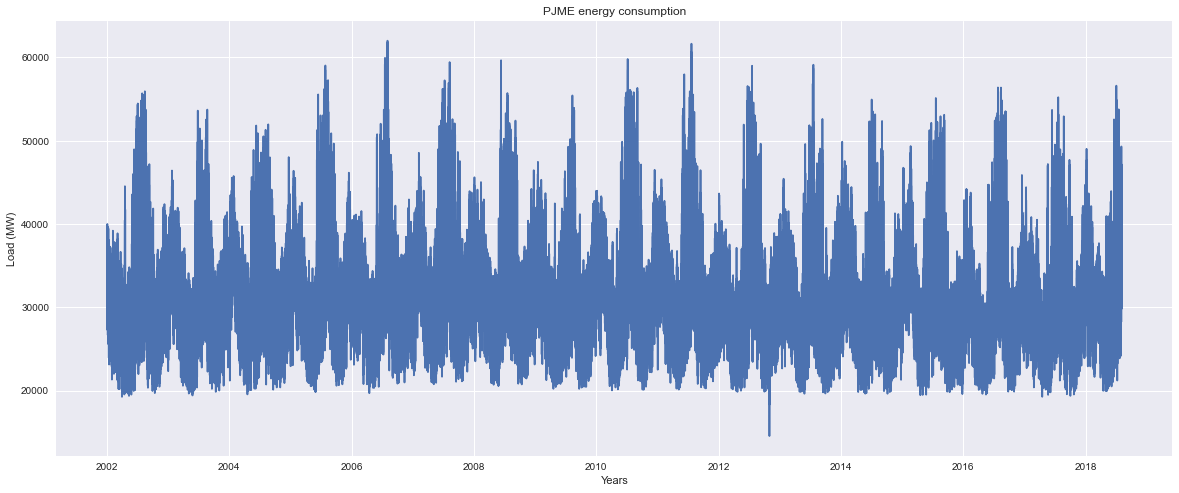

In [13]:
# removing all columns except PJME
df = df[['PJME']]

# removing the missing values
df.dropna(inplace=True)

# visualizing the data
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

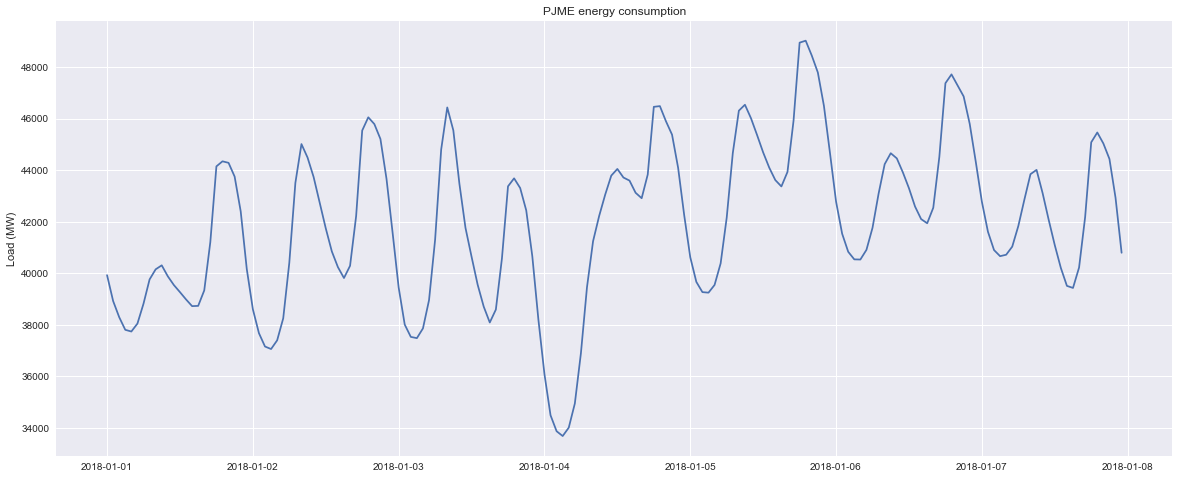

In [14]:
# visualizing a single week
plt.figure(figsize=(20, 8))
plt.plot(df['2018-01-01':'2018-01-07'])
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption')
plt.show()

In [15]:
# creating another df used for hourly, daily, weekly, monthly, yearly and seasonal analysis
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_year'] = df.index.day_of_year
df['quarter'] = df.index.quarter
df['season'] = df.index.month % 12 // 3 + 1
df['season'] = df['season'].replace({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})

df.head()

,PJME,hour,day_of_week,month,year,day_of_year,quarter,season
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,1,winter
2002-01-01 02:00:00,29265.0,2,1,1,2002,1,1,winter
2002-01-01 03:00:00,28357.0,3,1,1,2002,1,1,winter
2002-01-01 04:00:00,27899.0,4,1,1,2002,1,1,winter
2002-01-01 05:00:00,28057.0,5,1,1,2002,1,1,winter


Text(0.5, 1.0, 'PJME energy consumption by hour')

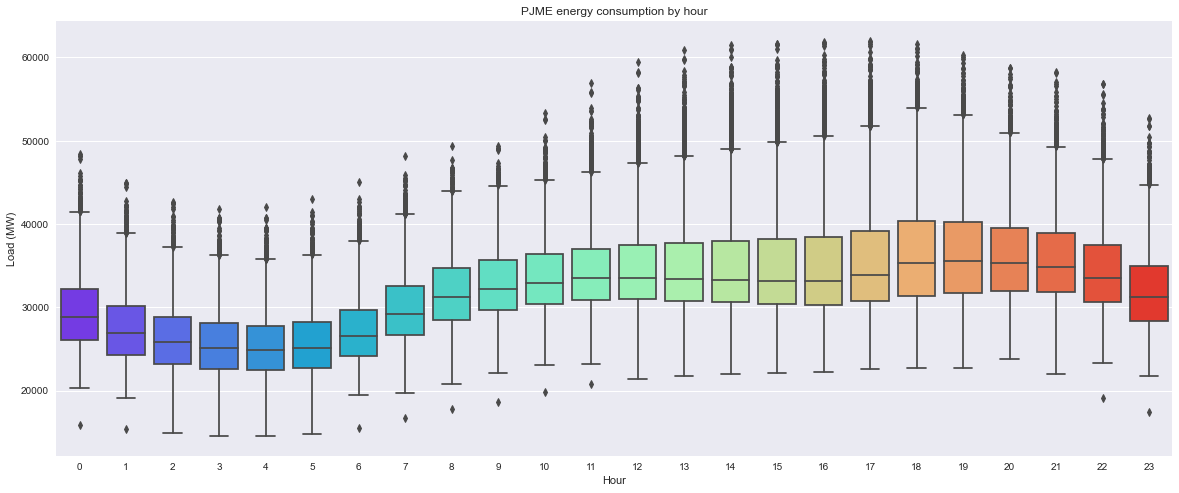

In [16]:
# we use seaborn to visualize the data
# plotting the hourly energy use

plt.figure(figsize=(20, 8))
sns.boxplot(x='hour', y='PJME', data=df, palette='rainbow')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by hour')

Text(0.5, 1.0, 'PJME energy consumption by month')

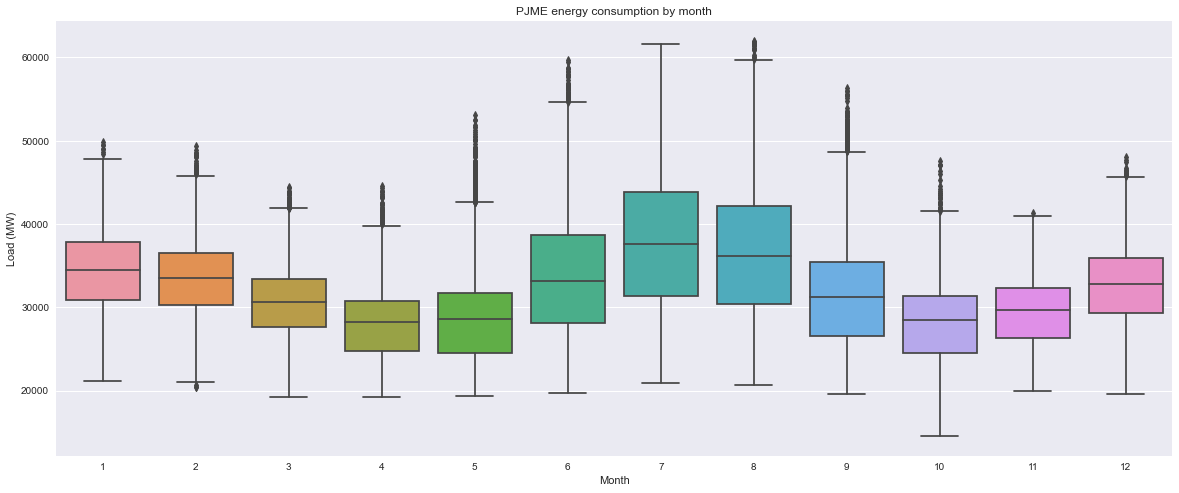

In [17]:
# plotting the monthly energy use

plt.figure(figsize=(20, 8))
sns.boxplot(x='month', y='PJME', data=df)
plt.xlabel('Month')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by month')


Text(0.5, 1.0, 'PJME energy consumption by day of week')

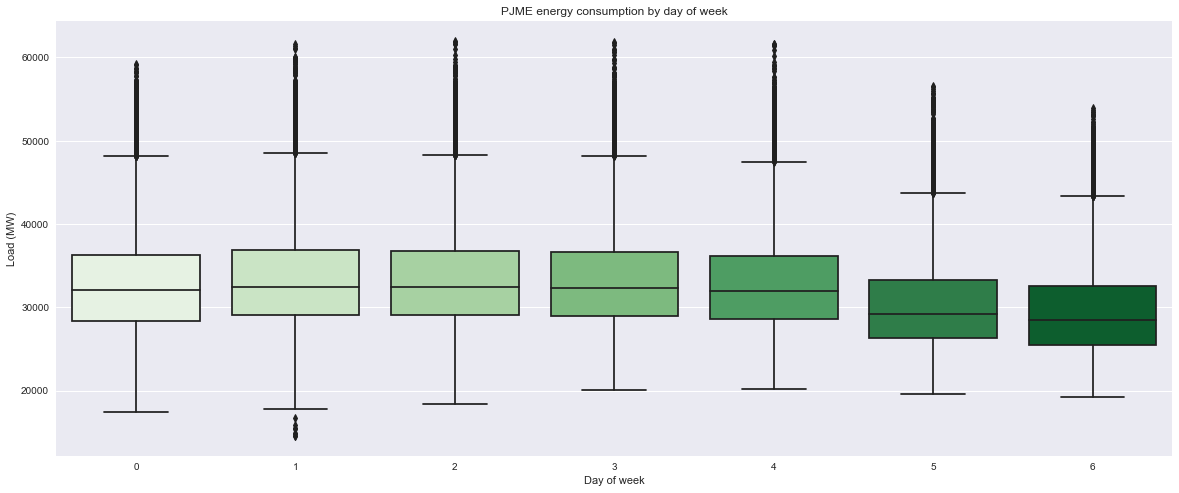

In [18]:
# plotting the daily energy use
plt.figure(figsize=(20, 8))
sns.boxplot(x='day_of_week', y='PJME', data=df, palette='Greens')
plt.xlabel('Day of week')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by day of week')

Text(0.5, 1.0, 'PJME energy consumption by season')

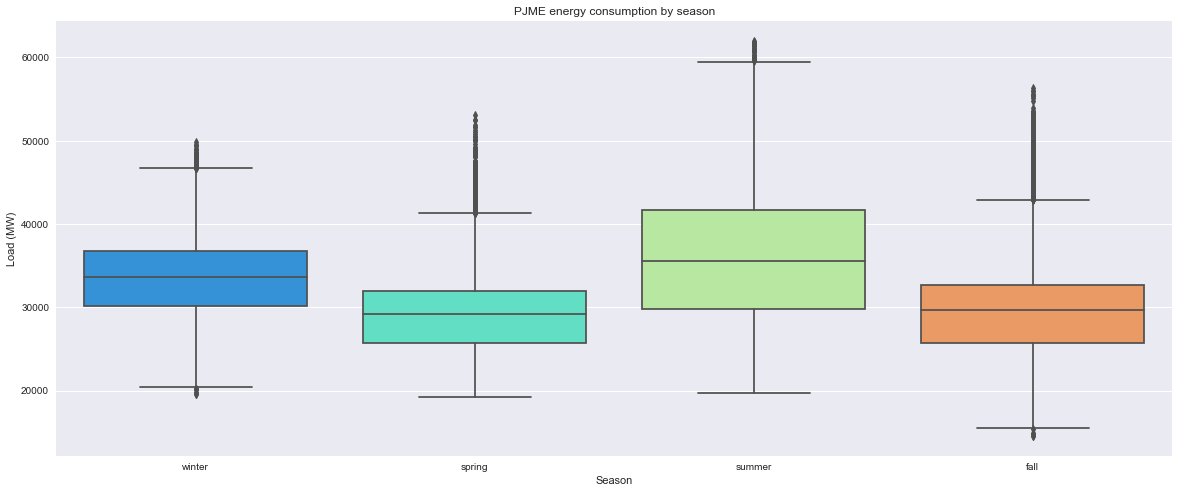

In [19]:
# plotting the seasonal energy use
plt.figure(figsize=(20, 8))
sns.boxplot(x='season', y='PJME', data=df, palette='rainbow')
plt.xlabel('Season')
plt.ylabel('Load (MW)')
plt.title('PJME energy consumption by season')


In [ ]:
# creating the model section
# 1st split the data into train and test
# 2nd create an XGBRegressor model
# 3rd fit the model
# 4th predict the values

# 5th evaluate the model score on weekly, monthly, yearly and seasonal basis

